In [30]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional
import numpy as np


@dataclass
class PlayerData:
    player_id: str
    data: Dict[str, np.ndarray] = field(default_factory=dict)
    timestamps: np.ndarray = field(default_factory=lambda: np.array([]))

    @classmethod
    def from_raw_data(
        cls, player_id: str, world: List[Dict], debug: List[Dict]
    ) -> "PlayerData":
        assert player_id.startswith("p")
        player = cls(player_id)
        player._process_raw_data(world, debug)
        return player

    def _process_raw_data(self, world: List[Dict], debug: List[Dict]) -> None:
        pid = int(self.player_id[1:])
        # Extract player data from world
        player_world = {
            w["timestamp"]: next(
                (p for p in w["data"]["World"]["own_players"] if p["id"] == pid), None
            )
            for w in world
        }
        player_world = {
            k: v
            for k, v in player_world.items()
            if v is not None and len(v) > 0
        }

        # Extract player debug data
        player_debug = {
            d["timestamp"]: {
                k[len(self.player_id) :]: v
                for k, v in d["data"]["Debug"].items()
                if k.startswith(self.player_id) and len(v) > 0
            }
            for d in debug
            if len(d["data"]["Debug"]) > 0
        }

        # Merge data
        shorter = (
            player_world if len(player_world) < len(player_debug) else player_debug
        )
        longer = player_debug if len(player_world) < len(player_debug) else player_world
        merged_player = {}
        for t, p in shorter.items():
            closest = min(longer.keys(), key=lambda x: abs(x - t))
            merged_player[t] = {**p, **longer[closest]}

        # Process merged data
        self.timestamps = np.array(sorted(merged_player.keys()))
        for key in set().union(*merged_player.values()):
            values = [merged_player[t].get(key) for t in self.timestamps]
            if all(isinstance(x, (int, float)) or x is None for x in values):
                self.data[key] = np.array(values, dtype=float)
            else:
                self.data[key] = np.array(values, dtype=object)

    def get_data_in_window(
        self,
        keys: List[str],
        start_time: Optional[float] = None,
        end_time: Optional[float] = None,
    ) -> Dict[str, np.ndarray]:
        if start_time is None:
            start_time = self.timestamps[0]
        if end_time is None:
            end_time = self.timestamps[-1]

        mask = (self.timestamps >= start_time) & (self.timestamps <= end_time)
        result = {}
        for key in keys:
            if key in self.data:
                result[key] = self.data[key][mask]
                
        if len(keys) == 1:
            return result[keys[0]]
        return result

In [3]:
data = json.load(open('../log-spinnies.json'))
world = [
    d for d in data if "data" in d and "World" in d["data"]
]
debug = [
    d for d in data if "data" in d and "Debug" in d["data"]
]

print(f"Ids: {[ p['id'] for p in world[-1]['data']['World']['own_players'] ]}")

Ids: [4, 3]


In [4]:
p3 = PlayerData.from_raw_data("p3", world, debug)
p4 = PlayerData.from_raw_data("p4", world, debug)

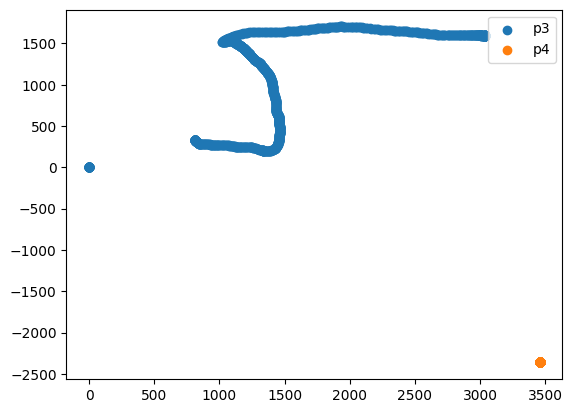

In [25]:
pos3 = p3.get_data_in_window(["position"], None, None)
pos4 = p4.get_data_in_window(["position"], None, None)

plt.scatter(pos3[:, 0], pos3[:, 1], label="p3")
plt.scatter(pos4[:, 0], pos4[:, 1], label="p4")
plt.legend()

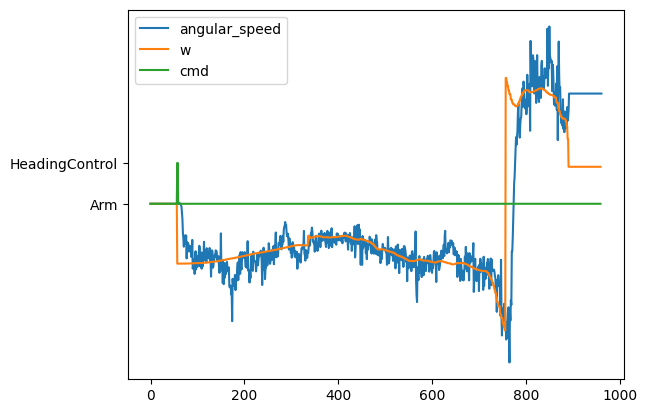

In [78]:
# plt.plot([d["data"] for d in p3.data[".active_skill"] if d is not None])
plt.plot([d for d in p3.data["angular_speed"] if d is not None], label="angular_speed")
plt.plot([-d["data"] for d in p3.data[".w"] if d is not None], label="w")
plt.plot([cmd["data"] for cmd in p3.data[".robot_cmd"] if cmd is not None], label="cmd")
plt.legend()

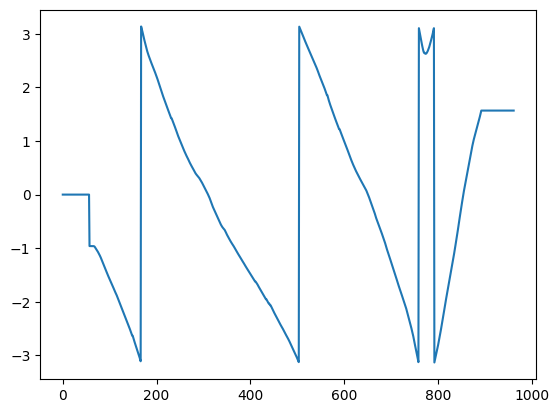

In [12]:
plt.plot([d for d in p3.data["yaw"] if d is not None])

In [53]:
p3.data.keys()

dict_keys(['timestamp', '.velocity', 'primary_status', 'imu_status', 'kicker_cap_voltage', 'pack_voltages', 'raw_yaw', 'breakbeam_ball_detected', 'raw_position', 'angular_speed', 'kicker_temp', 'velocity', '.dribble_speed', '.sx', '.active_skill', '.robot_cmd', '.target_yaw_line', '.breakbeam', 'id', 'kicker_status', '.w', '.yaw_control', '.collision', '.control.target', '.sy', '.acc', 'yaw', 'position'])

array([[  31.4760018 , -298.34419939],
       [  31.52253779, -298.33928607],
       [  31.56243204, -298.33506814],
       ...,
       [ 185.24745253,  235.97326402],
       [ 185.24745253,  235.97326402],
       [ 185.24745253,  235.97326402]])

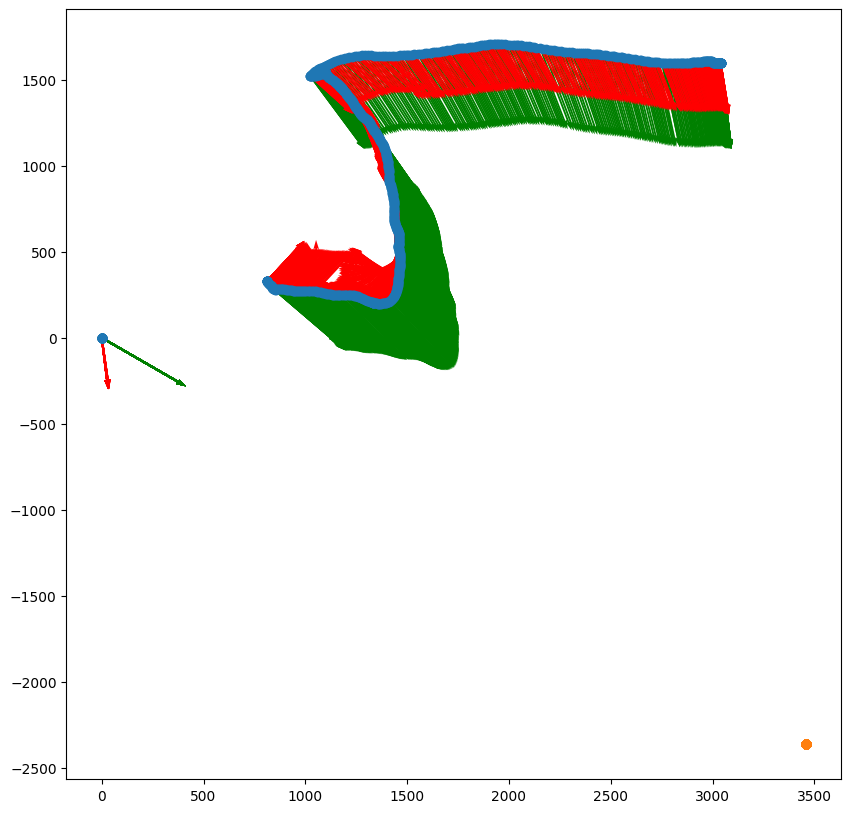

In [72]:
p3_pos = p3.get_data_in_window(["position"], None, None).astype(float)
p4_pos = p4.get_data_in_window(["position"], None, None).astype(float)

if len(p3_pos) < len(p4_pos):
    p4_pos = p4_pos[:len(p3_pos)]
elif len(p4_pos) < len(p3_pos):
    p3_pos = p3_pos[:len(p4_pos)]
    
angle = np.arctan2(np.array(p4_pos[:, 1] - p3_pos[:, 1]), np.array(p4_pos[:, 0] - p3_pos[:, 0]))
directions = np.array([np.cos(angle), np.sin(angle)]).T * 500

target_yaw = p3.get_data_in_window([".target_yaw_line"], None, None)
target_yaw_start = np.array([t["data"]["data"]["start"] for t in target_yaw if t is not None])
target_yaw_end = np.array([t["data"]["data"]["end"] for t in target_yaw if t is not None])
target_yaw = (target_yaw_end - target_yaw_start) * 10

if len(p3_pos) > len(target_yaw):
    p3_pos = p3_pos[:len(target_yaw)]
    directions = directions[:len(target_yaw)]

fig = plt.figure(figsize=(10, 10))
plt.quiver(p3_pos[:, 0], p3_pos[:, 1], directions[:, 0], directions[:, 1], angles='xy', scale_units='xy', scale=1, color='g')
plt.quiver(p3_pos[:, 0], p3_pos[:, 1], target_yaw[:, 0], target_yaw[:, 1], angles='xy', scale_units='xy', scale=1, color='r')
plt.scatter(p3_pos[:, 0], p3_pos[:, 1], label="p3")
plt.scatter(p4_pos[:, 0], p4_pos[:, 1], label="p4")
# plt.plot(angle)
target_yaw

TypeError: unhashable type: 'dict'

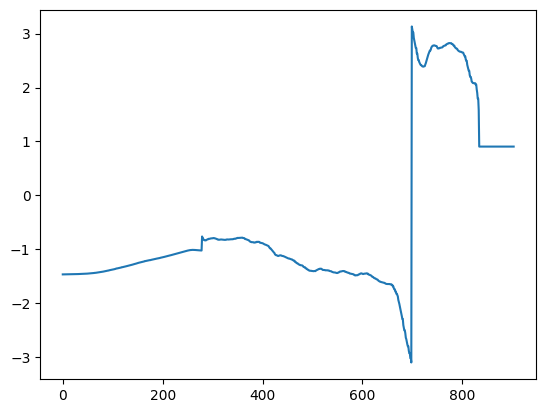

In [74]:
yaw_line = np.arctan2(target_yaw[:, 1], target_yaw[:, 0])
w = p3.get_data_in_window([".w"], None, None)

plt.plot(yaw_line)
plt.plot(w)

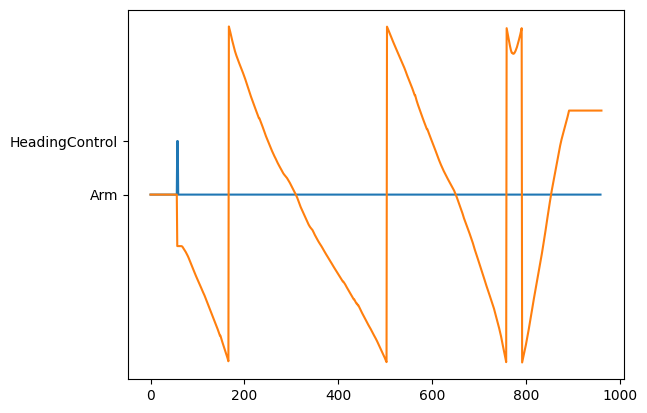

In [22]:
plt.plot([d["data"] for d in p3.data[".robot_cmd"] if d is not None ])
plt.plot([d for d in p3.data["yaw"] if d is not None])